### Hospital Inpatient Mortality Prediction
#### By Roger Sarvate
#### (Built using Python version 3.6.5)

#### About dataset:

This project utilizes the Kaggle dataset titled "2015 de-identified NY inpatient discharges (SPARCS)" (https://www.kaggle.com/jonasalmeida/2015-deidentified-ny-inpatient-discharge-sparcs). The source of the data is the New York State government website (http://health.data.ny.gov). 

The dataset contains some 2.3 million records of discharged inpatient hospital admissions at various hospitals in NY state in the year 2015, along with several characteristics of the patient being admitted (age range, gender, race) and information pertinent to the hospital admission, such as admit type (ER, trauma center, elective, etc.) and two different fields for the patient's diagnosis based on two separate diagnosis-classification systems: CCS (Clinical Classifications Software) and APR DRG (All Patient Refined Diagnosis Related Group). 

There are additional fields related to the condition and status of the patient. The field "Patient Disposition" indicates whether the patient after discharge is continuing home/self care, is receiving additional special care, or has expired. 

All records have been de-identified in this dataset to prevent identification of any specific individuals.

#### The project:

Using patient characteristics and diagnosis information at the time of admission to the hospital/facility, I will aim to build a model that predicts whether a given patient expired or survived during the duration of his/her inpatient stay.

#### Approach used:

While characteristics such as Age Group, Gender, Race, and so on can directly be fed into the model as categorical variables to aid in prediction of the target variable (Expired/Not Expired), the diagnosis information requires a bit more involved approach to translate into information that the model can directly use to predict likelihood of expiration.

My approach was to examine which CCS Diagnosis Descriptions and which APR DRG Descriptions (e.g. "cancer", "asthma", "convulsions", "mood disorders", etc.) were associated with the highest proportion of patient fatalities in the data, and thereby use a ranking system for each diagnosis keyword to "score" the patient's mortality risk based purely on his/her CCS and APR diagnosis information. 

I then combined this diagnosis risk score with the aforementioned patient characteristics to create a training dataset for the model. I used Random Forests, an ensemble method for classification, to "learn" from the combined patient and diagnosis-risk characteristics which patients are likely to have died during their hospital stays, and which patients survived, and then make the predictions based on a test set.

#### Model performance results:

Highest overall accuracy attained:<b> 87.9% </b> <br>
False positive rate (living patients incorrectly predicted as having expired): <b> 12.1% </b> <br>
False negative rate (expired patients incorrectly predicted as having survived): <b> 28.2% </b> <br>


### Part 1: Data Preprocessing and Exploration

In [1]:
# Set working directory to location of dataset

import os
os.chdir('C:\\Users\\sarva\\Projects\\datasets\\')

In [2]:
# Read CSV file into pandas dataframe
# Only import relevant columns for our purposes

import pandas as pd

discharge = pd.read_csv('ny_inpatient_discharges.csv', usecols=['Age Group','Race','Ethnicity','Gender','Type of Admission',
                                                   'CCS Diagnosis Description','APR DRG Description',
                                                                'APR Risk of Mortality', 'Patient Disposition', 
                                                                'Payment Typology 1'])

# Separate dataset into portion for expired patients and non-expired patients

discharge_exp = discharge[discharge['Patient Disposition']=='Expired']
discharge_nonexp = discharge[discharge['Patient Disposition']!='Expired']


In [3]:
# View sample of the data

discharge.head()

,Age Group,Gender,Race,Ethnicity,Type of Admission,Patient Disposition,CCS Diagnosis Description,APR DRG Description,APR Risk of Mortality,Payment Typology 1
0,50 to 69,F,White,Not Span/Hispanic,Emergency,Home or Self Care,Mood disorders,Bipolar disorders,Minor,Medicaid
1,18 to 29,F,White,Not Span/Hispanic,Emergency,Home or Self Care,Mood disorders,Bipolar disorders,Minor,Medicaid
2,30 to 49,M,White,Not Span/Hispanic,Emergency,Home or Self Care,Mood disorders,Bipolar disorders,Minor,Medicaid
3,50 to 69,F,White,Not Span/Hispanic,Emergency,Home or Self Care,Asthma,Asthma,Minor,Medicare
4,50 to 69,M,White,Not Span/Hispanic,Emergency,Home or Self Care,Epilepsy; convulsions,Seizure,Moderate,Medicaid


C:\Users\sarva\Anaconda\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


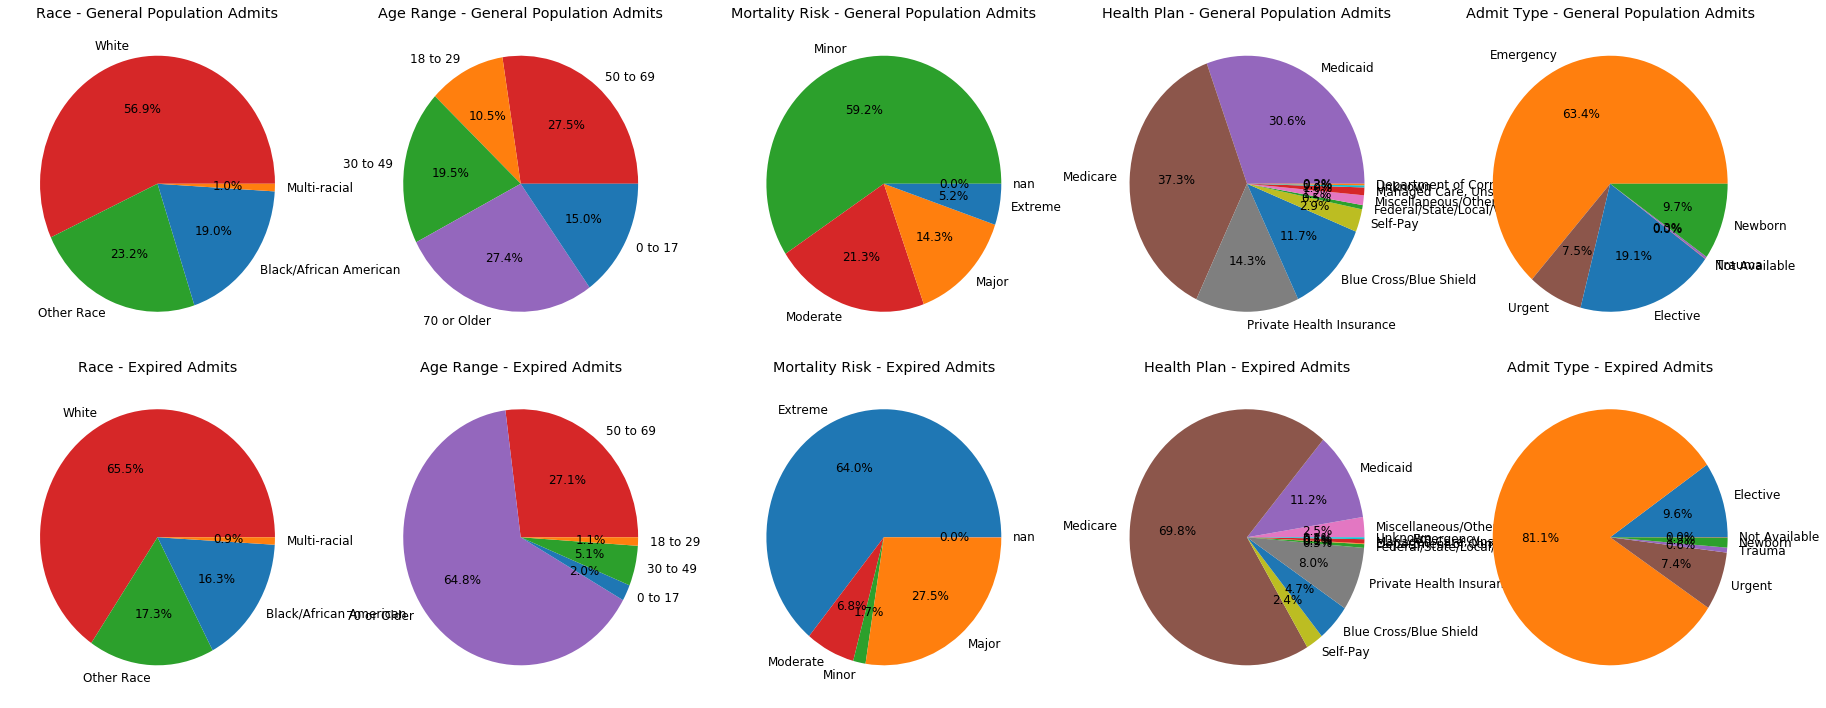

In [7]:
# Create a series of pie charts showing the mix of certain characterstics (e.g. age range, race, health insurance plan, etc.)
# and how these proportions differ between patients who expired and those who did not expire.


from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Use Counter object to create data dictionaries counting number of patients in each category
# for a given characteristic (e.g. Race: White:X, Black:Y, Other:Z, etc.)

race_count = Counter(discharge['Race'])
age_range_count = Counter(discharge['Age Group'])
risk_count = Counter(discharge['APR Risk of Mortality'])
plan_count = Counter(discharge['Payment Typology 1'])
admit_count = Counter(discharge['Type of Admission'])

race_count_exp = Counter(discharge_exp['Race'])
age_range_count_exp = Counter(discharge_exp['Age Group'])
risk_count_exp = Counter(discharge_exp['APR Risk of Mortality'])
plan_count_exp = Counter(discharge_exp['Payment Typology 1'])
admit_count_exp = Counter(discharge_exp['Type of Admission'])

discharge['APR Risk of Mortality'] = discharge['APR Risk of Mortality'].astype('category')
discharge_exp['APR Risk of Mortality'] = discharge_exp['APR Risk of Mortality'].astype('category')

# Define a standard 'dictionary' of pie chart colors for each group for each category
# so that the pie chart colors will be consistent between the expired and non-expired pie charts below

cdict_race = dict(zip(np.unique(discharge['Race'].values), plt.cm.tab10.colors))
cdict_age_range = dict(zip(np.unique(discharge['Age Group'].values), plt.cm.tab10.colors))
cdict_risk = dict(zip(np.unique(discharge['APR Risk of Mortality'].values), plt.cm.tab10.colors))
cdict_plan = dict(zip(np.unique(discharge['Payment Typology 1'].values), plt.cm.tab10.colors))
cdict_admit = dict(zip(np.unique(discharge['Type of Admission'].values), plt.cm.tab10.colors))

# Plot pie charts

plt.figure(figsize=(25,10))

plt.rcParams['font.size'] = 12

plt.subplot(2,5,1)
plt.pie(list(race_count.values()), labels=race_count.keys(), autopct='%.1f%%', 
       colors = [cdict_race[v] for v in race_count.keys()])
plt.title("Race - General Population Admits")

plt.subplot(2,5,2)
plt.pie(list(age_range_count.values()), labels=age_range_count.keys(), autopct='%.1f%%',
       colors = [cdict_age_range[v] for v in age_range_count.keys()])
plt.title("Age Range - General Population Admits")

plt.subplot(2,5,3)
plt.pie(list(risk_count.values()), labels=risk_count.keys(), autopct='%.1f%%',
       colors = [cdict_risk[v] for v in risk_count.keys()])
plt.title("Mortality Risk - General Population Admits")

plt.subplot(2,5,4)
plt.pie(list(plan_count.values()), labels=plan_count.keys(), autopct='%.1f%%',
       colors = [cdict_plan[v] for v in plan_count.keys()])
plt.title("Health Plan - General Population Admits")

plt.subplot(2,5,5)
plt.pie(list(admit_count.values()), labels=admit_count.keys(), autopct='%.1f%%',
       colors = [cdict_admit[v] for v in admit_count.keys()])
plt.title("Admit Type - General Population Admits")

plt.subplot(2,5,6)
plt.pie(list(race_count_exp.values()), labels=race_count_exp.keys(), autopct='%.1f%%',
       colors = [cdict_race[v] for v in race_count_exp.keys()])
plt.title("Race - Expired Admits")

plt.subplot(2,5,7)
plt.pie(list(age_range_count_exp.values()), labels=age_range_count_exp.keys(), autopct='%.1f%%',
       colors = [cdict_age_range[v] for v in age_range_count_exp.keys()])
plt.title("Age Range - Expired Admits")

plt.subplot(2,5,8)
plt.pie(list(risk_count_exp.values()), labels=risk_count_exp.keys(), autopct='%.1f%%',
       colors = [cdict_risk[v] for v in risk_count_exp.keys()])
plt.title("Mortality Risk - Expired Admits")

plt.subplot(2,5,9)
plt.pie(list(plan_count_exp.values()), labels=plan_count_exp.keys(), autopct='%.1f%%',
       colors = [cdict_plan[v] for v in plan_count_exp.keys()])
plt.title("Health Plan - Expired Admits")

plt.subplot(2,5,10)
plt.pie(list(admit_count_exp.values()), labels=admit_count_exp.keys(), autopct='%.1f%%',
       colors = [cdict_admit[v] for v in admit_count_exp.keys()])
plt.title("Admit Type - Expired Admits")

plt.tight_layout()
plt.show()

The above pie chart shows how expired and non-expired patients' characteristics differ. As expected, patients who expired are disproportionately old (70 and above age range), on Medicare plan which is used by elderly patients, were classified by APR Risk Mortality as "Extreme", and were admitted to the Emergency Room. 

Less obvious is the fact that expired patients were disproportionately white, and that relatively few expired patients had Medicaid compared to the general population.

### Part 2: Translating Diagnosis Information to Risk Scores

In [8]:
import string

word_list = set()
split_list = []

# Separate each keyword in the CCS Diagnosis Description field and create a unique set of all keywords for all records

for i in discharge['CCS Diagnosis Description']:
    split_list = i.split()
    for v in split_list:
        word_list.add(v.lower().replace(';','').replace(')','').replace('(',''))
        
CCS_diag_set = word_list
        
word_list = set()
split_list = []

# Repeat for APR DRG Description
        
for i in discharge['APR DRG Description']:
    split_list = i.split()
    for v in split_list:
        word_list.add(v.lower().replace(';','').replace(')','').replace('(',''))
        
APR_diag_set = word_list
    

In [9]:
exp_words_dict = dict()
nonexp_words_dict = dict()


# create dictionaries with respect to expired vs. non-expired datasets
# showing how many times each keyword in CCS/APR unique word sets appeared
# among patients who expired, and among patients who did not expire
    
for i in CCS_diag_set:
    word_count = 0
    for j in discharge_exp['CCS Diagnosis Description']:
        if i in j.lower():
            word_count = word_count + 1
    exp_words_dict.update({i:word_count})


for i in CCS_diag_set:
    word_count = 0    
    for j in discharge_nonexp['CCS Diagnosis Description']:
        if i in j.lower():
            word_count = word_count + 1
    nonexp_words_dict.update({i:word_count})

In [10]:
# Calculate a CCS "risk score" for each keyword based on how many times it appears
# in the non-expired patients dictionary and how many times it appears in the expired
# patients dictionary. More instances in the "expired" dictionary means higher risk score.

CCS_word_risk_score_dict = dict()

for i in CCS_diag_set:
    sum_count = exp_words_dict[i]+nonexp_words_dict[i]
    
    adj_risk_calc = ((0)*(nonexp_words_dict[i])+(100)*(exp_words_dict[i]))/sum_count
    
    CCS_word_risk_score_dict.update({i:adj_risk_calc})

In [11]:
exp_words_dict = dict()
nonexp_words_dict = dict()
    
# repeat same process as above for APR Diagnosis keywords
    
for i in APR_diag_set:
    word_count = 0
    for j in discharge_exp['APR DRG Description']:
        if i in j.lower():
            word_count = word_count + 1
    exp_words_dict.update({i:word_count})


for i in APR_diag_set:
    word_count = 0    
    for j in discharge_nonexp['APR DRG Description']:
        if i in j.lower():
            word_count = word_count + 1
    nonexp_words_dict.update({i:word_count})

In [12]:
APR_word_risk_score_dict = dict()

for i in APR_diag_set:
    sum_count = exp_words_dict[i]+nonexp_words_dict[i]
    
    adj_risk_calc = ((0)*(nonexp_words_dict[i])+(100)*(exp_words_dict[i]))/sum_count
    
    APR_word_risk_score_dict.update({i:adj_risk_calc})

In [13]:
# For each patient admission record, calculate that patient's overall risk score 
# for CCS and APR by averaging individual keywords' scores.

CCS_score = []
APR_score = []

for i in discharge['CCS Diagnosis Description']:
    average_list = []
    for j in i.split():
        if j.lower() in CCS_word_risk_score_dict:
            average_list.append(CCS_word_risk_score_dict[j.lower()])
    CCS_score.append(np.floor(np.mean(average_list)*100))

    
for i in discharge['APR DRG Description']:
    average_list = []
    for j in i.split():
        if j.lower() in APR_word_risk_score_dict:
            average_list.append(APR_word_risk_score_dict[j.lower()])
    APR_score.append(np.floor(np.mean(average_list)*100))

In [14]:
# Use a bell-curve (normal) approximation to translate the CCS and APR scores above
# into a scale from 0 to 1000 which indicates approximately what percentage of patients
# have a lower risk score. 
# For example:
# 200 = 20% of patients have a lower risk score.
# 500 = 50% of patients have a lower risk score, etc.

import scipy.stats as st

mean_CCS = np.mean(CCS_score)
mean_APR = np.mean(APR_score)
std_CCS = np.std(CCS_score)
std_APR = np.std(APR_score)

CCS_norm = []
APR_norm = []

for i in CCS_score:
    CCS_norm.append(np.floor(st.norm.cdf((i-mean_CCS)/std_CCS)*1000))
    
    
for i in APR_score:
    APR_norm.append(np.floor(st.norm.cdf((i-mean_APR)/std_APR)*1000))

In [15]:
discharge['CCS_score'] = CCS_score
discharge['APR_score'] = APR_score
discharge['CCS_norm'] = CCS_norm
discharge['APR_norm'] = APR_norm

In [16]:
discharge.head()

,Age Group,Gender,Race,Ethnicity,Type of Admission,Patient Disposition,CCS Diagnosis Description,APR DRG Description,APR Risk of Mortality,Payment Typology 1,CCS_score,APR_score,CCS_norm,APR_norm
0,50 to 69,F,White,Not Span/Hispanic,Emergency,Home or Self Care,Mood disorders,Bipolar disorders,Minor,Medicaid,33.0,65.0,263.0,287.0
1,18 to 29,F,White,Not Span/Hispanic,Emergency,Home or Self Care,Mood disorders,Bipolar disorders,Minor,Medicaid,33.0,65.0,263.0,287.0
2,30 to 49,M,White,Not Span/Hispanic,Emergency,Home or Self Care,Mood disorders,Bipolar disorders,Minor,Medicaid,33.0,65.0,263.0,287.0
3,50 to 69,F,White,Not Span/Hispanic,Emergency,Home or Self Care,Asthma,Asthma,Minor,Medicare,30.0,6.0,259.0,212.0
4,50 to 69,M,White,Not Span/Hispanic,Emergency,Home or Self Care,Epilepsy; convulsions,Seizure,Moderate,Medicaid,62.0,56.0,302.0,275.0


### Part 3: Preparing Model Input Dataset

In [17]:
# Translate target variable (Expired / Not Expired) into a categorical binary variable.

Expired = []

for i in discharge['Patient Disposition']:
    if i=='Expired':
        Expired.append(1)
    else:
        Expired.append(0)
        
discharge['Expired'] = Expired

In [18]:
# Only retain columns which will be used in model for prediction (dependent variables)
# as well as the target variable.

discharge_data = discharge[['Age Group','Gender','Race','Ethnicity','Type of Admission',
                            'Payment Typology 1','CCS_norm','APR_norm','Expired']]

discharge_data.head()

,Age Group,Gender,Race,Ethnicity,Type of Admission,Payment Typology 1,CCS_norm,APR_norm,Expired
0,50 to 69,F,White,Not Span/Hispanic,Emergency,Medicaid,263.0,287.0,0
1,18 to 29,F,White,Not Span/Hispanic,Emergency,Medicaid,263.0,287.0,0
2,30 to 49,M,White,Not Span/Hispanic,Emergency,Medicaid,263.0,287.0,0
3,50 to 69,F,White,Not Span/Hispanic,Emergency,Medicare,259.0,212.0,0
4,50 to 69,M,White,Not Span/Hispanic,Emergency,Medicaid,302.0,275.0,0


In [19]:
# Create categorical "dummy" variables for Age Group, Gender, Race, Ethnicity, Type of Admission, Health Insurance

discharge_data=pd.concat([discharge_data,pd.get_dummies(discharge_data['Age Group'])],axis=1)
discharge_data=pd.concat([discharge_data,pd.get_dummies(discharge_data['Race'])],axis=1)
discharge_data=pd.concat([discharge_data,pd.get_dummies(discharge_data['Ethnicity'])],axis=1)
discharge_data=pd.concat([discharge_data,pd.get_dummies(discharge_data['Type of Admission'])],axis=1)
discharge_data=pd.concat([discharge_data,pd.get_dummies(discharge_data['Payment Typology 1'])],axis=1)
discharge_data = discharge_data.drop(['Age Group', 'Gender','Race','Ethnicity','Type of Admission','Payment Typology 1'], axis=1)

In [20]:
# Scale the CCS and APR normal score data to be used in training model

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

discharge_data[['CCS_norm', 'APR_norm']] = scaler.fit_transform(discharge_data[['CCS_norm', 'APR_norm']])

In [21]:
# Separate input dataset into portion for expired patients and for non-expired patients.
# Drop the "Expired" indicator from input dataset and separate it into a target values (y) dataset

discharge_data_exp = discharge_data[discharge_data['Expired']==1]
discharge_data_nonexp = discharge_data[discharge_data['Expired']==0]

y = discharge_data['Expired']
X = discharge_data.drop(['Expired'],axis=1).values

y_exp = discharge_data_exp['Expired']
X_exp = discharge_data_exp.drop(['Expired'],axis=1).values

y_nonexp = discharge_data_nonexp['Expired']
X_nonexp = discharge_data_nonexp.drop(['Expired'],axis=1).values

y = discharge_data['Expired']
X = discharge_data.drop(['Expired'],axis=1).values


In [22]:
# Split input dataset into training and test portion for model.

import random

from sklearn.model_selection import train_test_split

# NOTE: Because the proportion of patients expired is small in the dataset (<3%), 
# I am boosting the proportion of expired patients in the training set to deal with
# this sparse data and therefore improve the model's ability to predict expired patients.

# Therefore, for the training set I am using a large portion of all expired patients (95%)
# and a small portion of all non-expired patients (5%).

X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_exp, y_exp, test_size=0.05, random_state=42)

X_train_nonexp, X_test_nonexp, y_train_nonexp, y_test_nonexp = train_test_split(X_nonexp, y_nonexp, 
                                                                                test_size=0.95, random_state=42)
X_train = np.concatenate((X_train_exp, X_train_nonexp))
y_train = np.concatenate((y_train_exp, y_train_nonexp))

X_test =  np.concatenate((X_test_exp, X_test_nonexp))
y_test =  np.concatenate((y_test_exp, y_test_nonexp))

# Randomly shuffle test and training set rows after concatenating

X_train, X_null1, y_train, y_null1 = train_test_split(X_train, y_train, test_size=0.0000001, random_state=0)

X_null2, X_test, y_null2, y_test = train_test_split(X_test, y_test, test_size=0.9999999, random_state=0)

### Part 4: Model Implementation and Prediction

In [24]:
# Import Random Forest Classifier with default parameters 
# and no restrictions on depths, leaves, etc.

# Train model, print out performance and confusion matrix on test set
# to determine sensitivty and specificity of model.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

print("Overall accuracy: {:.3f}".format(clf.score(X_test, y_test)))

CM = confusion_matrix(y_test, clf.predict(X_test))

print(CM)

print("False positive rate: {:.3f}".format(CM[0][1]/sum(CM[0])))
print("False negative rate: {:.3f}".format(CM[1][0]/sum(CM[1])))

C:\Users\sarva\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Overall accuracy: 0.879
[[1916399  264579]
 [    719    1831]]
False positive rate: 0.121
False negative rate: 0.282


### Conclusions

Although the overall model classification accuracy is close to <b>90%</b>, the false positive and false negative rates derived from the confusion matrix provide more useful information. Approximately <b>12%</b> of the patients who are admitted to the hospital (given their characteristics and diagnosis information) and then discharged while still alive will be incorrectly predicted by the model as expiring during their stay. Approximately <b>28%</b> of the patients who expire during their stay will be incorrectly predicted by the model as surviving until the time of discharge.

A greater sensitivity of the model (i.e. less false negatives) would be a valuable improvement, as it could identify which patients are facing a greater likelihood of death in the hospital and should therefore should receive more attention, resources, treatment, etc. The false positive rate may be less concerning, because it is smaller, and the diversion of resources and attention to patients who are identified as being more likely to die by the model could well be the determinant factor in their survival.

It is worth noting that because the diagnosis risk scores are specifically calibrated to the keywords contained within this dataset, the methodology used may not work equally well with other datasets in the general hospital patient population, if, for example, medical professionals use different terms and descriptions to characterize patients' diagnoses. However, to the extent that CCS and APR DRG Descriptions are standardized nationwide as in the above dataset, a model such as this one could be a helpful predictor of mortality risk upon admission for patients in the general population.